In [1]:
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
def linear_acc(data):
    alpha = 0.9
    linearacc = pd.DataFrame()
    g = 0           
    for r in range(len(data)):      #1行ずつ見る   
        #Isolate the force of gravity with the low-pass filter.
        g = alpha*g + (1-alpha) * data.loc[r]
        #Remove the gravity contribution with the high-pass filter.
        linear = data.loc[r] - g
        linearacc =linearacc.append(linear,ignore_index=True)
    return linearacc

In [3]:
m_path = "/Users/takeshin/odrive/sozolab_gdrive/students/Shingo/BerkeleyMHAD/Mocap/OpticalData/moc_s01_a01_r01.txt"
acc_path = "/Users/takeshin/odrive/sozolab_gdrive/students/Shingo/BerkeleyMHAD/Accelerometer/Shimmer01/acc_h01_s01_a01_r01.txt"

mocap_sampling_rate = 480
acc_sampling_rate = 30
decimate_factor = mocap_sampling_rate/acc_sampling_rate

In [4]:
#accelerometer
acc_df = pd.read_csv(acc_path, sep=' ', header=None)
acc_df = acc_df[[0,1,2]]
acc_df.interpolate(inplace=True)
acc_df = linear_acc(acc_df)
acc_df = sig.medfilt(acc_df.values, kernel_size = [3,1]) #median filter on columns

In [5]:
#motion capture
axis = ['X', 'Y', 'Z']
markers = 43
header_s = ['m_'+str(i)+'_'+ax for i in range(1, markers+1) for ax in axis]
#header.append('frame_number')
header_total = list(header_s + ['frame_number','time'])

df = pd.read_csv(m_path, sep=' ', header=None,names=header_total)
df.replace(to_replace=0, value=np.NaN, inplace = True)
df.interpolate(inplace=True)
df.replace(to_replace=np.NaN, value=0, inplace = True)


#use marker 16 for acc 1
df = df[['m_16_X', 'm_16_Y','m_16_Z']] #,'m_17_X', 'm_17_Y','m_17_Z']]
#unit conversion
df = sig.medfilt(df, kernel_size = [3,1]) #median filter on columns

#decimate down sampling
df = sig.decimate(df, q=int(decimate_factor), axis=0)

#take gradient 
vel_df = np.gradient(df, axis=0)
grad_df = np.gradient(vel_df, axis=0) #second derivative 
grad_df = grad_df*0.001*900/9.80665 #unit conversion

#accelerometer only reads 2 grav
grad_df[grad_df>1.5]=1.5
grad_df[grad_df<-1.5]=-1.5


/Users/takeshin/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/takeshin/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


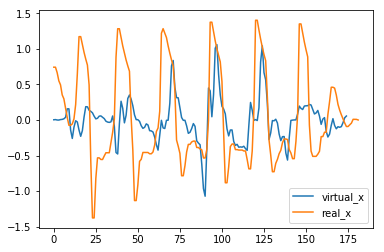

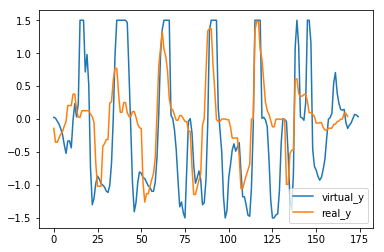

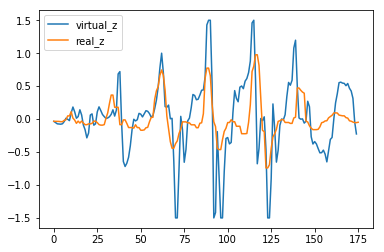

In [12]:
plt.plot(grad_df[:,0],label='virtual_x')
plt.plot(acc_df[:,0], label='real_x')
plt.legend()
plt.show()

plt.plot(grad_df[:,1],label='virtual_y')
plt.plot(acc_df[13:,1], label='real_y')
plt.legend()
plt.show()

plt.plot(grad_df[:,2],label='virtual_z')
plt.plot(acc_df[6:,2], label='real_z')
plt.legend()
plt.show()
